# Jupyter Notebook UI to graph your baseline behavioural data - Altered specifically for Andrew Snow's MWT Project

Version 1.3 - Joseph Liang, Rankin Lab
Updated:
1. Upgraded folder path selection application
2. Upgraded dataset management (less moving parts for end-user)
3. output changed from tif -> png

## Beginner Essentials:
1. Shift-Enter to run each cell. After you run, you should see an output "done step #". If not, an error has occured
2. When inputting your own code/revising the code, make sure you close all your quotation marks '' and brackets (), [], {}.
3. Don't leave any commas (,) hanging! (make sure an object always follows a comma. If there is nothing after a comma, remove the comma!
4. Learning to code? Each line of code is annotated to help you understand how this code works!

## 3. Run all cells/steps sequentially, even the ones that do not require input


# 1. Importing Packages Required (No input required, just run)

In [1]:
import pandas as pd #<- package used to import and organize data
import numpy as np #<- package used to import and organize data
import seaborn as sns #<- package used to plot graphs
from matplotlib import pyplot as plt #<- package used to plot graphs
import os #<- package used to work with system filepaths
from ipywidgets import widgets #<- widget tool to generate button
from IPython.display import display #<- displays button
# from tkinter import Tk, filedialog #<- Tkinter is a GUI package
from tqdm.notebook import tqdm
from ipyfilechooser import FileChooser
# import dask.dataframe as dd
import pingouin as pg
import random
pd.set_option('display.max_columns', 50)
print("done step 1")

done step 1


# 2. Pick filepath (just run and click button)

Run the following cell and click the button 'Select Folder' to pick a filepath.

### Important: Later on, this script uses the total file path for each file to import and group data. That means if your folder has whatever your strain is named, the script will not work.

(ex. if your folder has "N2" in it this script sees all files inside this folder as having the "N2" search key)

### An easy fix is to just rename your folder to something else (make your strains lower-case, or just have the date)

In [2]:
starting_directory='/Users/Joseph/Desktop/'
chooser=FileChooser(starting_directory)
display(chooser)

FileChooser(path='/Users/Joseph/Desktop', filename='', title='', show_hidden=False, select_desc='Select', chan…

In [3]:
folder_path=chooser.selected_path
print(folder_path)

/Users/Joseph/Desktop/AndrewSnow/March5_2025_Baseline


# 3. User Defined Variables (Add input here)

### Setting time bins


In [4]:
# Setting 1s Bins: for 0.5s Bins: 0,360,721
bins = np.arange(0,10801,1) # 1 second bins (start, end, steps in between)

print(bins)

print(len(bins))
print("done step 3")

[    0     1     2 ... 10798 10799 10800]
10801
done step 3


# 4. Construct filelist from folder path (No input required, just run)

In [5]:
#folder_path = '/Users/Joseph/Desktop/lrk1_ATR_NoATR_08_15_2019'
print(folder_path)
os.chdir(folder_path) #<- setting your working directory so that your images will be saved here

filelist = list() #<- empty list
for root, dirs, files in os.walk(folder_path): #<- this for loop goes through your folder 
    for name in files:
        if name.endswith('.dat'): #<- and takes out all files with a .dat (file that contains your data)
            filepath = os.path.join(root, name) #<- Notes down the file path of each data file
            filelist.append(filepath) #<- saves it into the list
    
print(filelist)
print('done step 4')

/Users/Joseph/Desktop/AndrewSnow/March5_2025_Baseline
['/Users/Joseph/Desktop/AndrewSnow/March5_2025_Baseline/miz306/20250305_151649/miz306_7x3_f7220C_600s_C0305cd.01185.dat', '/Users/Joseph/Desktop/AndrewSnow/March5_2025_Baseline/miz306/20250305_151649/miz306_7x3_f7220C_600s_C0305cd.01191.dat', '/Users/Joseph/Desktop/AndrewSnow/March5_2025_Baseline/miz306/20250305_151649/miz306_7x3_f7220C_600s_C0305cd.02315.dat', '/Users/Joseph/Desktop/AndrewSnow/March5_2025_Baseline/miz306/20250305_151649/miz306_7x3_f7220C_600s_C0305cd.00700.dat', '/Users/Joseph/Desktop/AndrewSnow/March5_2025_Baseline/miz306/20250305_151649/miz306_7x3_f7220C_600s_C0305cd.00066.dat', '/Users/Joseph/Desktop/AndrewSnow/March5_2025_Baseline/miz306/20250305_151649/miz306_7x3_f7220C_600s_C0305cd.00674.dat', '/Users/Joseph/Desktop/AndrewSnow/March5_2025_Baseline/miz306/20250305_151649/miz306_7x3_f7220C_600s_C0305cd.00338.dat', '/Users/Joseph/Desktop/AndrewSnow/March5_2025_Baseline/miz306/20250305_151649/miz306_7x3_f7220C_60

# 5. Process Data Function (No input required, just run)

In [6]:
def ProcessData(strain): #<- an example of a user-defined function
    strain_filelist = []  #<- empty list
    for i in filelist: #<- goes through the list and filters for keyword
        if strain in i:
            strain_filelist.append(i)
    Strain_N = len(strain_filelist) #<- N per strain, or number of plates
    if Strain_N > 1000:
        strain_filelist = random.sample(strain_filelist,1000)
    Strain_N = len(strain_filelist)
    print(f'This Strain has {Strain_N} worms tracked') #<- prints out number of plates per strain
    for i, f in tqdm(enumerate(strain_filelist, start=1)): #<- a progress bar function integrated into data import
        N = len(strain_filelist)
        statement = f"Processing {i} of {N} worms" #<- progress bar statement
        try:
            DF_Read = pd.read_csv(f, sep=' ', skiprows = 0, header = None) #<- imports and cleans data
        except Exception:
            pass
        DF_Read['plate_id'] = f.split('/')[-2].split('_')[1]
        DF_Read['date'] = f.split('/')[-2].split('_')[0]
        if i==1:
            DF_Total = DF_Read
            DF_Total = DF_Total.dropna(axis=0)
            DF_Total["worm"]=i
            DF_Total=DF_Total.dropna()
#             print(DF_Total)
        else:
            DF_Add = DF_Read
            DF_Add = DF_Add.dropna(axis=0)
            DF_Add["worm"]=i
            DF_Total = pd.concat((DF_Total, DF_Add), ignore_index = True)  #<- imports and cleans data
        print(statement)
#         print(DF_Total)
    DF_Total = DF_Total.dropna(axis = 0) #<- more data cleaning
    DF_Total = DF_Total.rename( #<- more data cleaning
                {0:'time',
                1:'speed',
                2: "x",
                3: "y",
                4: "angularspeed",
                5: "pathlength",
                6: "kink",
                7: "bias",
                8: "curve",
                9: "dir",
                10: "crab",
                11: "length",
                12: "midline",
                13: "width",
                14: "morphwidth",
                15: "area"
                }, axis=1)
#     print(DF_Total)

    #0.5s Bins
    Bins = [float(i) for i in bins] #<- adds time bins into the data frame
    DF_Total['time_bin'] = pd.cut(DF_Total['time'], Bins, labels = Bins[1:])
    DF_Total['time_bin'] = DF_Total['time_bin'].astype(np.float64)
    DF_time_bin=DF_Total.groupby(["time_bin", "worm", "plate_id", "date"], as_index=False).mean()
    # DF_time_bin = DF_time_bin[(300 <= DF_time_bin["time_bin"])&(400 >= DF_time_bin["time_bin"])]
    
    # DF_time_bin=DF_Total.groupby(["date", "plate_id"], as_index=False).mean()
#     print(DF_time_bin)
    #     DF_Speed_DF = DF_Total[["time", "time_bin", "speed", "x", "y", "x_0","y_0", "pathlength", "worm"]].copy()
    
    return{
            'N': Strain_N,
            'Confirm':DF_time_bin, #DF_Total if want to non-binned data
#             'Speed_DF': DF_Speed_DF, #<- this is the finished product we will use for analysis
            'Filelist':strain_filelist} 

print('done step 5')

done step 5


# 6.1 Processing Data (Automated - just run)

In [7]:
strainnames=[]
for f in filelist:
    strainnames.append(f.split('/')[-3])
ustrainnames=list(set(strainnames))
print(ustrainnames)
ustrainnames.sort()

nstrains=list(range(1,len(ustrainnames)+1))

StrainNames = {}
StrainNames = {nstrains[i]: ustrainnames[i] for i in range(len(nstrains))}
print(StrainNames)
print("done step 6.1")

['N2', 'miz306', 'miz304']
{1: 'N2', 2: 'miz304', 3: 'miz306'}
done step 6.1


# 6.2 Process Data (just run this cell)

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
DataLists = [0] #<- generates empty list. 0 is there to account for python's index starting at 0. 
# we want indexing to start at 1 (when I say #1 I want the first point, not the second point)

for s in tqdm(StrainNames.values()): #<- goes through the dictionary in step 6.1 and processes data
    if not s == '':
        DataLists.append(ProcessData(s)['Confirm']) #<- appends all data into a list of dataframes
# print(DataLists[2])
print('done step 6.2')

  0%|          | 0/3 [00:00<?, ?it/s]

This Strain has 1000 worms tracked


0it [00:00, ?it/s]

Processing 1 of 1000 worms
Processing 2 of 1000 worms
Processing 3 of 1000 worms
Processing 4 of 1000 worms
Processing 5 of 1000 worms
Processing 6 of 1000 worms
Processing 7 of 1000 worms
Processing 8 of 1000 worms
Processing 9 of 1000 worms
Processing 10 of 1000 worms
Processing 11 of 1000 worms
Processing 12 of 1000 worms
Processing 13 of 1000 worms
Processing 14 of 1000 worms
Processing 15 of 1000 worms
Processing 16 of 1000 worms
Processing 17 of 1000 worms
Processing 18 of 1000 worms
Processing 19 of 1000 worms
Processing 20 of 1000 worms
Processing 21 of 1000 worms
Processing 22 of 1000 worms
Processing 23 of 1000 worms
Processing 24 of 1000 worms
Processing 25 of 1000 worms
Processing 26 of 1000 worms
Processing 27 of 1000 worms
Processing 28 of 1000 worms
Processing 29 of 1000 worms
Processing 30 of 1000 worms
Processing 31 of 1000 worms
Processing 32 of 1000 worms
Processing 33 of 1000 worms
Processing 34 of 1000 worms
Processing 35 of 1000 worms
Processing 36 of 1000 worms
P

0it [00:00, ?it/s]

Processing 1 of 1000 worms
Processing 2 of 1000 worms
Processing 3 of 1000 worms
Processing 4 of 1000 worms
Processing 5 of 1000 worms
Processing 6 of 1000 worms
Processing 7 of 1000 worms
Processing 8 of 1000 worms
Processing 9 of 1000 worms
Processing 10 of 1000 worms
Processing 11 of 1000 worms
Processing 12 of 1000 worms
Processing 13 of 1000 worms
Processing 14 of 1000 worms
Processing 15 of 1000 worms
Processing 16 of 1000 worms
Processing 17 of 1000 worms
Processing 18 of 1000 worms
Processing 19 of 1000 worms
Processing 20 of 1000 worms
Processing 21 of 1000 worms
Processing 22 of 1000 worms
Processing 23 of 1000 worms
Processing 24 of 1000 worms
Processing 25 of 1000 worms
Processing 26 of 1000 worms
Processing 27 of 1000 worms
Processing 28 of 1000 worms
Processing 29 of 1000 worms
Processing 30 of 1000 worms
Processing 31 of 1000 worms
Processing 32 of 1000 worms
Processing 33 of 1000 worms
Processing 34 of 1000 worms
Processing 35 of 1000 worms
Processing 36 of 1000 worms
P

0it [00:00, ?it/s]

Processing 1 of 1000 worms
Processing 2 of 1000 worms
Processing 3 of 1000 worms
Processing 4 of 1000 worms
Processing 5 of 1000 worms
Processing 6 of 1000 worms
Processing 7 of 1000 worms
Processing 8 of 1000 worms
Processing 9 of 1000 worms
Processing 10 of 1000 worms
Processing 11 of 1000 worms
Processing 12 of 1000 worms
Processing 13 of 1000 worms
Processing 14 of 1000 worms
Processing 15 of 1000 worms
Processing 16 of 1000 worms
Processing 17 of 1000 worms
Processing 18 of 1000 worms
Processing 19 of 1000 worms
Processing 20 of 1000 worms
Processing 21 of 1000 worms
Processing 22 of 1000 worms
Processing 23 of 1000 worms
Processing 24 of 1000 worms
Processing 25 of 1000 worms
Processing 26 of 1000 worms
Processing 27 of 1000 worms
Processing 28 of 1000 worms
Processing 29 of 1000 worms
Processing 30 of 1000 worms
Processing 31 of 1000 worms
Processing 32 of 1000 worms
Processing 33 of 1000 worms
Processing 34 of 1000 worms
Processing 35 of 1000 worms
Processing 36 of 1000 worms
P

# 7. Grouping Data and Naming (Automated - just run)

In [10]:
TotalConcatenated=pd.concat(df.assign(Strain=StrainNames.get(i+1)) for i,df in enumerate(DataLists[1:]))
TotalConcatenated=TotalConcatenated.rename(columns={"Strain": "Tracker"})
# TotalConcatenated[['Genotype', 'Treatment']] = TotalConcatenated['Strain'].str.split('_', 1, expand=True)
# TotalConcatenated=TotalConcatenated.dropna()
# TotalConcatenated = TotalConcatenated.reset_index(drop=True)
print(TotalConcatenated)
print(os.getcwd())
TotalConcatenated.to_csv("Baseline_output.csv")
# print("done output")
print('done step 7')

       time_bin  worm plate_id      date        time     speed          x  \
0           4.0   212   074822  20250305    3.968000  0.327600   7.917300   
1           4.0   255   150359  20250305    3.579300  0.245730  11.140980   
2           4.0   293   150359  20250305    3.943000  0.245200  30.221200   
3           4.0   521   150359  20250305    3.740167  0.187467  22.578817   
4           4.0   534   150359  20250305    3.539364  0.233173  11.970018   
...         ...   ...      ...       ...         ...       ...        ...   
99768     600.0   975   080112  20250305  599.515778  0.046378  38.937422   
99769     600.0   978   150105  20250305  599.499333  0.019100  24.668689   
99770     600.0   979   150105  20250305  599.499333  0.004622  29.019022   
99771     600.0   986   150105  20250305  599.499333  0.020311  30.047922   
99772     600.0   998   080112  20250305  599.487100  0.107080  23.139860   

               y  angularspeed  pathlength        kink  bias      curve  \


## Add time tolerances here for experiments with no taps

In [ ]:
times = np.linspace(0,10800,37)
times_minus1 = times-1
times_plus1 = times+1
times_minus2 = times-2
times_plus2 = times+2
fiveminrangetimes = np.concatenate([times_minus2,times_minus1,times,times_plus1,times_plus2])
print(fiveminrangetimes)

## Add time tolerances to increase N here if you add taps

In [ ]:
times = np.linspace(0,10800,37)
times_plus1 = times+1
times_plus2 = times+2
times_plus3 = times+3
times_plus4 = times+4
times_plus5 = times+5
times_plus6 = times+6
times_plus7 = times+7
fiveminrangetimes = np.concatenate([times,times_plus1,times_plus2,times_plus3,times_plus4,times_plus5,times_plus6,times_plus2])
print(fiveminrangetimes)

In [ ]:
every5min = TotalConcatenated[TotalConcatenated['time_bin'].isin(fiveminrangetimes)].reset_index(drop=True).rename(columns={"Strain": "MWT"})
every5min["aspect"]=every5min["length"]/every5min["width"]
every5min["roundedtimebin"] = round(every5min["time_bin"]/100)*100
print(every5min)

In [ ]:
every5min.to_csv("5_min_data.csv")

In [ ]:
listofcolumns=['roundedtimebin','worm','plate_id','date','Tracker']
final_5min = every5min.groupby(listofcolumns).mean(numeric_only =True)
final_5min.columns = final_5min.columns.get_level_values(0)
final_5min = final_5min.reset_index()
print(final_5min)

In [ ]:
final_5min.to_csv("final_5min.csv")

# Area Finding Tracker A

In [ ]:
sns.set_context("notebook")
plt.figure(linewidth = 2.5)
plt.gca().xaxis.grid(False)
sns.scatterplot(x=final_5min[final_5min['Tracker']=='MWTA']['x'], y=final_5min[final_5min['Tracker']=='MWTA']['y']*-1, data=final_5min[final_5min['Tracker']=='MWTA'],hue='roundedtimebin')
plt.title("MWT-A")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig('MWT-A Positional Graph.png', format='png', dpi=450, bbox_inches='tight')

In [ ]:
# Utils widgets
from ipywidgets import FloatText
from ipywidgets import GridspecLayout, Layout
import itertools

def create_textfield(description):
    return FloatText(description=description, value=0, layout=Layout(height='auto', width='auto'))

grida = GridspecLayout(4, 3)
gridb = GridspecLayout(4, 3)
gridc = GridspecLayout(4, 3)

i_list=["X_min", "X_max", "Y_min", "Y_max"]
j_list=["N2", "304", "306"]
name_tuple=list(itertools.product(j_list, i_list))
# print(name_tuple)

name_list = [''.join(i) for i in name_tuple]

# print(name_list)
print("For MWT-A")

for i in range(len(i_list)):
    for j in range(len(j_list)):
        grida[i, j] = create_textfield('{}-{}'.format(j_list[j], i_list[i]))
grida

In [ ]:
print("For MWT-A:")
print("-"*50)
print(grida[0,0].description,":",grida[0,0].value)
print(grida[1,0].description,":",grida[1,0].value)
print(grida[2,0].description,":",grida[2,0].value)
print(grida[3,0].description,":",grida[3,0].value)

print(grida[0,1].description,":",grida[0,1].value)
print(grida[1,1].description,":",grida[1,1].value)
print(grida[2,1].description,":",grida[2,1].value)
print(grida[3,1].description,":",grida[3,1].value)

print(grida[0,2].description,":",grida[0,2].value)
print(grida[1,2].description,":",grida[1,2].value)
print(grida[2,2].description,":",grida[2,2].value)
print(grida[3,2].description,":",grida[3,2].value)


# Area Finding Tracker B

In [ ]:
sns.set_context("notebook")
plt.figure(linewidth = 2.5)
plt.gca().xaxis.grid(False)
sns.scatterplot(x=final_5min[final_5min['Tracker']=='MWTB']['x'], y=final_5min[final_5min['Tracker']=='MWTB']['y']*-1, data=final_5min[final_5min['Tracker']=='MWTB'],hue='roundedtimebin')
plt.title("MWT-B")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig('MWT-B Positional Graph.png', format='png', dpi=450, bbox_inches='tight')

In [ ]:
print("For MWT-B")

for x in range(len(i_list)):
    for y in range(len(j_list)):
        gridb[x, y] = create_textfield('{}-{}'.format(j_list[y], i_list[x]))
gridb

In [ ]:
print("For MWT-B:")
print("-"*50)
print(gridb[0,0].description,":",gridb[0,0].value)
print(gridb[1,0].description,":",gridb[1,0].value)
print(gridb[2,0].description,":",gridb[2,0].value)
print(gridb[3,0].description,":",gridb[3,0].value)

print(gridb[0,1].description,":",gridb[0,1].value)
print(gridb[1,1].description,":",gridb[1,1].value)
print(gridb[2,1].description,":",gridb[2,1].value)
print(gridb[3,1].description,":",gridb[3,1].value)

print(gridb[0,2].description,":",gridb[0,2].value)
print(gridb[1,2].description,":",gridb[1,2].value)
print(gridb[2,2].description,":",gridb[2,2].value)
print(gridb[3,2].description,":",gridb[3,2].value)


# Area Finding Tracker C

In [ ]:
sns.set_context("notebook")
plt.figure(linewidth = 2.5)
plt.gca().xaxis.grid(False)
sns.scatterplot(x=final_5min[final_5min['Tracker']=='MWTC']['x'], y=final_5min[final_5min['Tracker']=='MWTC']['y']*-1, data=final_5min[final_5min['Tracker']=='MWTC'], hue='roundedtimebin')
plt.title("MWT-C")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig('MWT-C Positional Graph.png', format='png', dpi=450, bbox_inches='tight')

In [ ]:
print("For MWT-C")

for a in range(len(i_list)):
    for b in range(len(j_list)):
        gridc[a, b] = create_textfield('{}-{}'.format(j_list[b], i_list[a]))
gridc

In [ ]:
print("For MWT-C:")
print("-"*50)

print(gridc[0,0].description,":",gridc[0,0].value)
print(gridc[1,0].description,":",gridc[1,0].value)
print(gridc[2,0].description,":",gridc[2,0].value)
print(gridc[3,0].description,":",gridc[3,0].value)

print(gridc[0,1].description,":",gridc[0,1].value)
print(gridc[1,1].description,":",gridc[1,1].value)
print(gridc[2,1].description,":",gridc[2,1].value)
print(gridc[3,1].description,":",gridc[3,1].value)

print(gridc[0,2].description,":",gridc[0,2].value)
print(gridc[1,2].description,":",gridc[1,2].value)
print(gridc[2,2].description,":",gridc[2,2].value)
print(gridc[3,2].description,":",gridc[3,2].value)


In [ ]:
print(every5min)
print(range(len(every5min)))

# Assigning Strain To Each Plate By Region

In [ ]:
every5min=final_5min
Strain = []
for i in range(len(every5min)):
    if every5min['Tracker'][i] == 'MWTA':
        if grida[0,0].value <= every5min.x[i] <= grida[1,0].value and grida[2,0].value <= every5min.y[i] <= grida[3,0].value:
            Strain.append('N2')
        elif grida[0,1].value <= every5min.x[i] <= grida[1,1].value and grida[2,1].value <= every5min.y[i] <= grida[3,1].value:
            Strain.append('miz304')
        elif grida[0,2].value <= every5min.x[i] <= grida[1,2].value and grida[2,2].value <= every5min.y[i] <= grida[3,2].value:
            Strain.append('miz306')
        else : 
            Strain.append(np.nan) #When conditions are not met
    elif every5min['Tracker'][i] == 'MWTB':
        if gridb[0,0].value <= every5min.x[i] <= gridb[1,0].value and gridb[2,0].value <= every5min.y[i] <= gridb[3,0].value:
            Strain.append('N2')
        elif gridb[0,1].value <= every5min.x[i] <= gridb[1,1].value and gridb[2,1].value <= every5min.y[i] <= gridb[3,1].value:
            Strain.append('miz304')
        elif gridb[0,2].value <= every5min.x[i] <= gridb[1,2].value and gridb[2,2].value <= every5min.y[i] <= gridb[3,2].value:
            Strain.append('miz306')
        else : 
            Strain.append(np.nan) #When conditions are not met
    elif every5min['Tracker'][i] == 'MWTC':
        if gridc[0,0].value <= every5min.x[i] <= gridc[1,0].value and gridc[2,0].value <= every5min.y[i] <= gridc[3,0].value:
            Strain.append('N2')
        elif gridc[0,1].value <= every5min.x[i] <= gridc[1,1].value and gridc[2,1].value <= every5min.y[i] <= gridc[3,1].value:
            Strain.append('miz304')
        elif gridc[0,2].value <= every5min.x[i] <= gridc[1,2].value and gridc[2,2].value <= every5min.y[i] <= gridc[3,2].value:
            Strain.append('miz306')
        else : 
            Strain.append(np.nan) #When conditions are not met
            
every5min['Strain'] = Strain

print(every5min)

In [ ]:
every5min.to_csv("final_data_output.csv")

In [ ]:
measure_select=widgets.Dropdown(
            options=['speed', 'angularspeed', 'pathlength','kink', 'bias','curve','crab','length','midline','width','morphwidth','area','aspect'],
            value='speed',
            description='Pick a measure:',
            disabled=False)
display(measure_select)

In [ ]:
measure = measure_select.value

sns.set_context("notebook")
plt.figure(linewidth = 2.5)
plt.figure(figsize=(12,7))
plt.gca().xaxis.grid(False)
# sns.lineplot(data=TotalConcatenated,x='time_bin',y=measure,hue='Strain')
sns.boxplot(x="roundedtimebin", y=measure, data = every5min, hue='Strain',hue_order=["N2","miz304","miz306"])
# graph=sns.violinplot(x="roundedtimebin", y=measure, data = every5min, hue='Strain', hue_order=["N2","miz304","miz306"],split=True, gap=.1, inner='point')
# sns.swarmplot(x="roundedtimebin", y=measure, data = every5min, hue='Strain',hue_order=["N2","miz304","miz306"], dodge=True)

plt.xlabel("Time (s)")
plt.ylabel(f"{measure}")
plt.xticks(rotation=90)
# plt.title("")
# plt.ylim(top = 3)
# plt.ylim(bottom = 0)
# plt.xlim(left= 21)
# plt.xlim(right = 35.5)
# ax.legend(loc = 'upper right', fontsize = '10')
# plt.savefig(f'{measure}_data_zoomin.png', format='png', dpi=450)
plt.show()

# Baseline Metric Measurements (Taken from the last 10 seconds of the 600s baseline experiment)

In [35]:
last10seconds = TotalConcatenated[590 <= TotalConcatenated.time]
last10seconds = last10seconds.rename(columns={"Tracker": "Strain"})
last10seconds = last10seconds.groupby(by=["worm","plate_id","date","Strain"], as_index=False).mean().reset_index(drop=True)
last10seconds.to_csv("10secbaseline.csv")
last10seconds = last10seconds.sort_values(by=['Strain'], ascending = True)
last10seconds

,worm,plate_id,date,Strain,time_bin,time,speed,x,y,angularspeed,pathlength,kink,bias,curve,dir,crab,length,midline,width,morphwidth,area
245,497,074822,20250305,N2,595.5,595.018230,0.239391,11.357392,40.787100,8.289394,7.817742,36.838409,0.981818,29.766667,0.000280,0.018060,1.070980,1.203887,0.214713,0.109399,0.137341
216,455,070643,20250305,N2,595.5,595.018583,0.046138,20.996449,54.872072,4.237806,4.309661,47.415694,0.660000,33.134111,0.005249,0.008537,0.864814,1.044393,0.287700,0.122165,0.123324
220,461,150359,20250305,N2,595.5,595.005465,0.024816,3.453704,26.494668,1.892197,1.003401,56.883864,-0.322879,30.350727,0.004613,0.003680,0.847343,1.111772,0.275133,0.151863,0.152874
222,464,144712,20250305,N2,595.5,594.993866,0.020590,6.838193,33.726960,1.812444,15.143975,54.503111,0.150000,35.310833,0.000025,0.003340,0.720298,0.975231,0.321713,0.157399,0.130480
225,466,070643,20250305,N2,595.5,595.001685,0.115388,9.897838,32.526198,3.474227,7.714082,30.692374,0.937500,31.831033,0.000080,0.007818,0.943587,1.129032,0.251555,0.120079,0.133078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,238,151649,20250305,miz306,595.5,595.003530,0.012874,13.164604,36.595130,0.584423,22.050000,31.151859,0.000000,29.693910,0.000000,0.003863,0.786221,0.850074,0.146046,0.117900,0.098791
81,186,080112,20250305,miz306,595.5,594.999484,0.077202,38.460478,42.298955,7.039448,2.085687,51.045746,0.886667,37.363361,0.000289,0.011236,0.729714,0.988533,0.290670,0.120309,0.113640
195,405,143553,20250305,miz306,595.5,595.011502,0.069030,40.616235,36.399364,2.877949,2.055414,41.693537,0.115559,34.433036,0.039373,0.008176,0.923433,1.067673,0.170017,0.114679,0.128194
382,804,150105,20250305,miz306,595.5,595.010312,0.079050,16.087128,53.403563,0.951944,0.651881,14.734722,0.977778,8.500139,0.000025,0.001637,0.797835,0.805180,0.060664,0.054772,0.058729


In [18]:
baseline_measure_select=widgets.Dropdown(
            options=['speed', 'angularspeed', 'pathlength','kink', 'bias','curve','crab','length','midline','width','morphwidth','area','aspect'],
            value='speed',
            description='Pick a measure:',
            disabled=False)
display(baseline_measure_select)

Dropdown(description='Pick a measure:', options=('speed', 'angularspeed', 'pathlength', 'kink', 'bias', 'curve…

<Figure size 640x480 with 0 Axes>

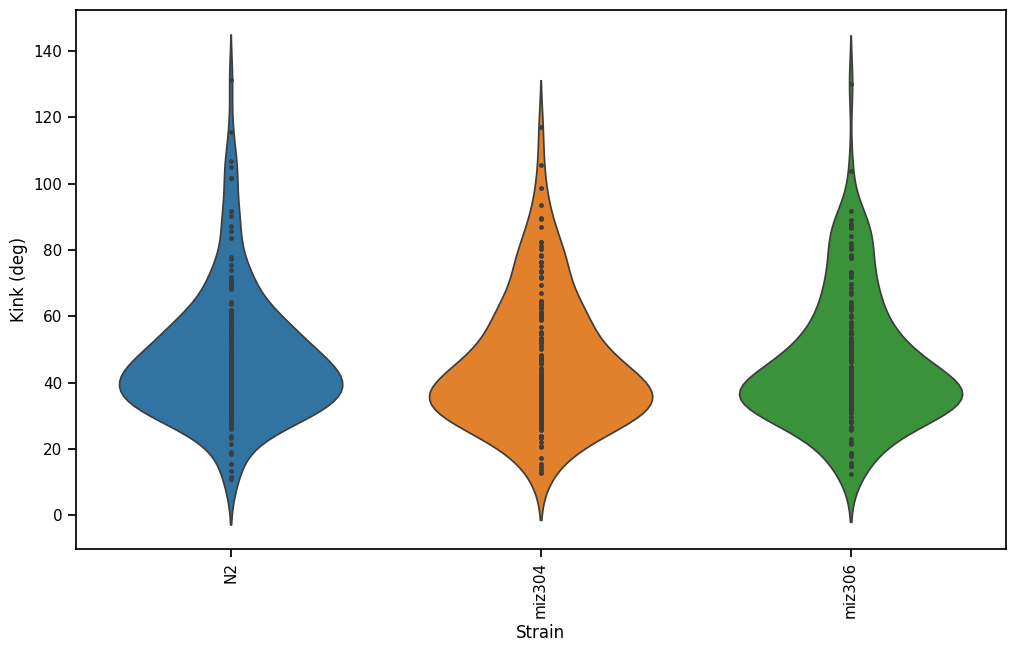

In [54]:
measure = baseline_measure_select.value

sns.set_context("notebook")
plt.figure(linewidth = 2.5)
plt.figure(figsize=(12,7))
plt.gca().xaxis.grid(False)
# sns.lineplot(data=TotalConcatenated,x='time_bin',y=measure,hue='Strain')
# sns.boxplot(x="Strain", y=measure, data = last10seconds, hue='Strain',hue_order=["N2","miz304","miz306"])
sns.violinplot(x="Strain", y=measure, data = last10seconds, hue='Strain', hue_order=["N2","miz304","miz306"], gap=.1, inner='point')
# graph=sns.violinplot(x="roundedtimebin", y=measure, data = every5min, hue='Strain', hue_order=["N2","miz304","miz306"],split=True, gap=.1, inner='point')
# sns.swarmplot(x="roundedtimebin", y=measure, data = every5min, hue='Strain',hue_order=["N2","miz304","miz306"], dodge=True)

plt.xlabel("Strain")
# plt.ylabel(f"{measure}")
plt.ylabel("Kink (deg)")
plt.xticks(rotation=90)
# plt.title("")
# plt.ylim(top = 3)
# plt.ylim(bottom = 0)
# plt.xlim(left= 21)
# plt.xlim(right = 35.5)
# ax.legend(loc = 'upper right', fontsize = '10')
plt.savefig(f'{measure}_data_zoomin.png', format='png', dpi=450)
plt.show()